In [52]:
# data processing
import pandas as pd
import numpy as np

# modelling
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Conv2D, MaxPooling2D, UpSampling2D, Dense, Conv2DTranspose, Input, Flatten, Layer, BatchNormalization, LeakyReLU, Dropout, Activation, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import binary_accuracy, Mean
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import mae, binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import Progbar

from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity

# visualization
import matplotlib.pyplot as plt
import seaborn as sn

# misc
import cv2
import math
import random as rn

Dataset split: 60000 train rows 60000 test rows


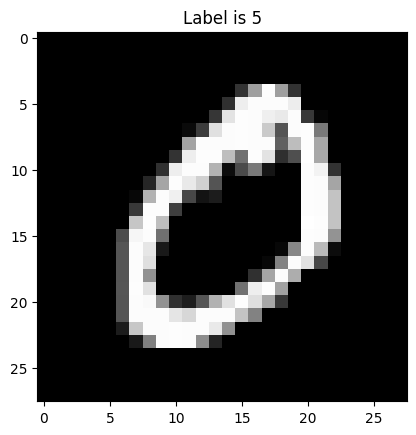

In [53]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f"Dataset split: {len(x_train.data)} train rows",
          f"{len(y_train.data)} test rows")

point = np.array(x_train[0], dtype='float')
point = point.reshape((28, 28))
plt.title('Label is {label}'.format(label=y_train[0]))
plt.imshow(x_train[1], cmap='gray')
plt.show()

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

In [55]:
# generator model define
def generator_model():
    inputs = Input((10,))
    fc1 = Dense(input_dim=10, units=128*7*7)(inputs)
    fc1 = BatchNormalization()(fc1)
    fc1 = LeakyReLU(0.2)(fc1)
    fc2 = Reshape((7, 7, 128), input_shape=(128*7*7,))(fc1)
    up1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(fc2)
    conv1 = Conv2D(64, (3, 3), padding='same')(up1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv1)
    conv2 = Conv2D(1, (5, 5), padding='same')(up2)
    outputs = Activation('sigmoid')(conv2)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [56]:
# discriminator model define
def discriminator_model():
    inputs = Input((28, 28, 1))
    conv1 = Conv2D(64, (5, 5), padding='same')(inputs)
    conv1 = LeakyReLU(0.2)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (5, 5), padding='same')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    fc1 = Flatten()(pool2)
    fc1 = Dense(1)(fc1)
    outputs = Activation('sigmoid')(fc1)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [57]:
### d_on_g model for training generator
def generator_containing_discriminator(g, d):
    d.trainable = False
    ganInput = Input(shape=(10,))
    x = g(ganInput)
    ganOutput = d(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

In [58]:
# functions
# combine images for visualization
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:4]
    image = np.zeros((height*shape[0], width*shape[1], shape[2]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1],:] = img[:, :, :]
    return image

# generate images
def generate(BATCH_SIZE):
    g = generator_model()
    g.load_weights('weights/generator.h5')
    noise = np.random.uniform(0, 1, (BATCH_SIZE, 10))
    generated_images = g.predict(noise)
    return generated_images

# anomaly loss function 
def sum_of_residual(y_true, y_pred):
    return K.sum(K.abs(y_true - y_pred))

# discriminator intermediate layer feautre extraction
def feature_extractor(d=None):
    if d is None:
        d = discriminator_model()
        d.load_weights('weights/discriminator.h5') 
    intermidiate_model = Model(inputs=d.layers[0].input, outputs=d.layers[-7].output)
    intermidiate_model.compile(loss='binary_crossentropy', optimizer='rmsprop')
    return intermidiate_model

# train generator and discriminator
def train(BATCH_SIZE, X_train):
    
    ### model define
    d = discriminator_model()
    g = generator_model()
    d_on_g = generator_containing_discriminator(g, d)
    d_optim = RMSprop(learning_rate=0.0004)
    g_optim = RMSprop(learning_rate=0.0002)
    g.compile(loss='mse', optimizer=g_optim)
    d_on_g.compile(loss='mse', optimizer=g_optim)
    d.trainable = True
    d.compile(loss='mse', optimizer=d_optim)
    

    for epoch in range(10):
        print ("Epoch is", epoch + 1)
        n_iter = int(X_train.shape[0]/BATCH_SIZE)
        progress_bar = Progbar(target=n_iter)
        
        for index in range(n_iter):
            # create random noise -> U(0,1) 10 latent vectors
            noise = np.random.uniform(0, 1, size=(BATCH_SIZE, 10))

            # load real data & generate fake data
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = g.predict(noise, verbose=0)
            
            # visualize training results
            if index % 20 == 0:
                image = combine_images(generated_images)
                image = image*127.5+127.5
                cv2.imwrite('./result/'+str(epoch)+"_"+str(index)+".png", image)

            # attach label for training discriminator
            x = np.concatenate((image_batch, generated_images))
            y = np.array([1] * BATCH_SIZE + [0] * BATCH_SIZE)
            
            # training discriminator
            d_loss = d.train_on_batch(x, y)

            # training generator
            d.trainable = False
            g_loss = d_on_g.train_on_batch(noise, np.array([1] * BATCH_SIZE))
            d.trainable = True

            progress_bar.update(index + 1, values=[('g',g_loss), ('d',d_loss)])
        print ('')

        # save weights for each epoch
        g.save_weights('weights/generator.h5', True)
        d.save_weights('weights/discriminator.h5', True)
    return d, g

# anomaly detection model define
def anomaly_detector(g=None, d=None):
    if g is None:
        g = generator_model()
        g.load_weights('weights/generator.h5')
    intermidiate_model = feature_extractor(d)
    intermidiate_model.trainable = False
    g = Model(inputs=g.layers[1].input, outputs=g.layers[-1].output)
    g.trainable = False
    # Input layer cann't be trained. Add new layer as same size & same distribution
    aInput = Input(shape=(10,))
    gInput = Dense((10), trainable=True)(aInput)
    gInput = Activation('sigmoid')(gInput)
    
    # G & D feature
    G_out = g(gInput)
    D_out= intermidiate_model(G_out)    
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights= [0.90, 0.10], optimizer='rmsprop')
    
    # batchnorm learning phase fixed (test) : make non trainable
    if d is not None:
        make_trainable(d, False)
    
    return model

def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
       l.trainable = val

# anomaly detection
def compute_anomaly_score(model, x, iterations=100, d=None):
    z = np.random.uniform(0, 1, size=(1, 10))
    
    intermidiate_model = feature_extractor(d)
    d_x = intermidiate_model.predict(x)

    # learning for changing latent
    loss = model.fit(z, [x, d_x], batch_size=32, epochs=iterations, verbose=0)
    similar_data, _ = model.predict(z)
    
    loss = loss.history['loss'][-1]
    
    return loss, similar_data

def anomaly_detection(test_img, g=None, d=None):
    model = anomaly_detector(g=g, d=d)
    ano_score, similar_img = compute_anomaly_score(model, test_img.reshape(1, 28, 28, 1), iterations=500, d=d)

    # anomaly area, 255 normalization
    np_residual = test_img.reshape(28,28,1) - similar_img.reshape(28,28,1)
    np_residual = (np_residual + 2)/4

    np_residual = (255*np_residual).astype(np.uint8)
    original_x = (test_img.reshape(28,28,1)*127.5+127.5).astype(np.uint8)
    similar_x = (similar_img.reshape(28,28,1)*127.5+127.5).astype(np.uint8)

    original_x_color = cv2.cvtColor(original_x, cv2.COLOR_GRAY2BGR)
    residual_color = cv2.applyColorMap(np_residual, cv2.COLORMAP_JET)
    show = cv2.addWeighted(original_x_color, 0.3, residual_color, 0.7, 0.)

    return ano_score, original_x, similar_x, show

def load_model():
    d = discriminator_model()
    g = generator_model()
    d_optim = RMSprop()
    g_optim = RMSprop(lr=0.0002)
    g.compile(loss='binary_crossentropy', optimizer=g_optim)
    d.compile(loss='binary_crossentropy', optimizer=d_optim)
    d.load_weights('./weights/discriminator.h5')
    g.load_weights('./weights/generator.h5')
    return g, d

In [59]:
# normalize data
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

labels = len(np.unique(y_train))

x_train = x_train[:, :, :, None]
x_test = x_test[:, :, :, None]
print ('train shape:', x_train.shape)
print ('test shape:', x_test.shape)
X_test_original = x_test.copy()

x_train = x_train[y_train==1]
x_test = x_test[y_test==1]
print ('train shape:', x_train.shape)
print ('test shape:', x_test.shape)

train shape: (60000, 28, 28, 1)
test shape: (10000, 28, 28, 1)
train shape: (6742, 28, 28, 1)
test shape: (1135, 28, 28, 1)


In [46]:
### 1. train generator & discriminator
Model_d, Model_g = train(64, x_train)

### 2. test generator
generated_img = generate(25)
img = combine_images(generated_img)
img = (img*127.5)+127.5
img = img.astype(np.uint8)
img = cv2.resize(img, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)

Epoch is 1
105/105 [==============================] - 56s 522ms/step - g: 0.1085 - d: 0.0083

Epoch is 2
105/105 [==============================] - 54s 517ms/step - g: 8.5501e-05 - d: 6.8331e-05

Epoch is 3
105/105 [==============================] - 54s 516ms/step - g: 4.3299e-05 - d: 2.7354e-04

Epoch is 4
105/105 [==============================] - 49s 471ms/step - g: 0.0145 - d: 0.0247

Epoch is 5
105/105 [==============================] - 49s 464ms/step - g: 0.1441 - d: 0.2152

Epoch is 6
105/105 [==============================] - 48s 462ms/step - g: 0.1270 - d: 0.2022

Epoch is 7
105/105 [==============================] - 50s 480ms/step - g: 0.0513 - d: 0.1161

Epoch is 8
105/105 [==============================] - 49s 470ms/step - g: 0.0130 - d: 0.0791

Epoch is 9
105/105 [==============================] - 48s 459ms/step - g: 0.0336 - d: 0.0946

Epoch is 10
105/105 [==============================] - 49s 464ms/step - g: 0.0376 - d: 0.0874

1/1 [==============================] - 0s 1

In [47]:
print("Training data shape: ", x_train.shape)
print("Training labels shape: ", y_train.shape)
print("Test data shape: ", x_test.shape)
print("Test labels shape: ", y_test.shape)

Training data shape:  (6742, 28, 28, 1)
Training labels shape:  (60000,)
Test data shape:  (1135, 28, 28, 1)
Test labels shape:  (10000,)


1/1 [==============================] - 0s 96ms/step
label 1 : done score 58.73
anomaly score :  58.7347412109375


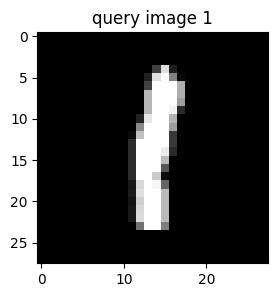

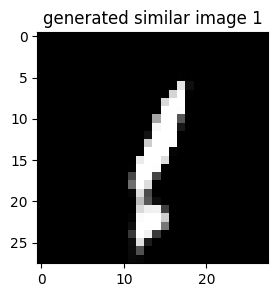

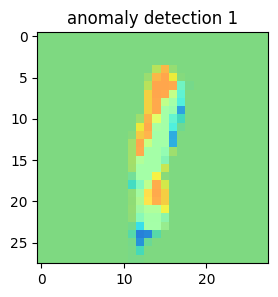

In [80]:
# compute anomaly score - sample from strange image
img_idx = 6
label_idx = 1
test_img = X_test_original[y_test==label_idx][img_idx]
#test_img = np.random.uniform(-1, 1, (28, 28, 1))

score, query, pred, diff = anomaly_detection(test_img)
print ('label ' + str(label_idx) + ' : done score', '%.2f'%score)
print("anomaly score : ", score)

## matplot view
plt.figure(1, figsize=(3, 3))
plt.title('query image ' + str(label_idx))
plt.imshow(query.reshape(28,28), cmap=plt.cm.gray)

plt.figure(2, figsize=(3, 3))
plt.title('generated similar image ' + str(label_idx))
plt.imshow(pred.reshape(28,28), cmap=plt.cm.gray)

plt.figure(3, figsize=(3, 3))
plt.title('anomaly detection ' + str(label_idx))
plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
plt.show()

random noise image
4/4 [==============================] - 0s 3ms/step


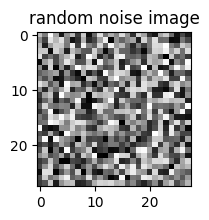

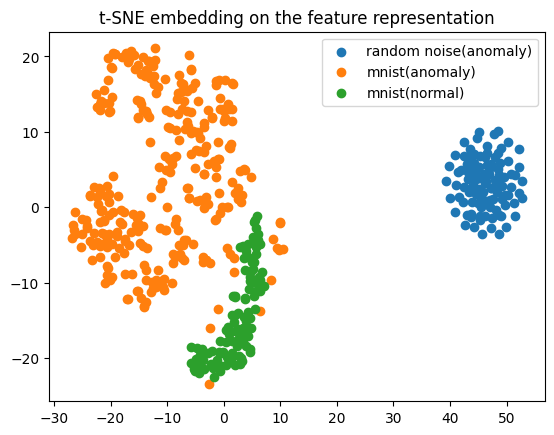

In [49]:
random_image = np.random.uniform(0, 1, (100, 28, 28, 1))
print("random noise image")
plt.figure(4, figsize=(2, 2))
plt.title('random noise image')
plt.imshow(random_image[0].reshape(28,28), cmap=plt.cm.gray)

# intermidieate output of discriminator
model = feature_extractor()
feature_map_of_random = model.predict(random_image, verbose=1)
feature_map_of_minist = model.predict(X_test_original[y_test != 1][:300], verbose=1)
feature_map_of_minist_1 = model.predict(x_test[:100], verbose=1)

# t-SNE for visulization
output = np.concatenate((feature_map_of_random, feature_map_of_minist, feature_map_of_minist_1))
output = output.reshape(output.shape[0], -1)
anomaly_flag = np.array([1]*100+ [0]*300)

X_embedded = TSNE(n_components=2).fit_transform(output)
plt.figure(5)
plt.title("t-SNE embedding on the feature representation")
plt.scatter(X_embedded[:100,0], X_embedded[:100,1], label='random noise(anomaly)')
plt.scatter(X_embedded[100:400,0], X_embedded[100:400,1], label='mnist(anomaly)')
plt.scatter(X_embedded[400:,0], X_embedded[400:,1], label='mnist(normal)')
plt.legend()
plt.show()